In [1]:
%env CUDA_LAUNCH_BLOCKING=1

env: CUDA_LAUNCH_BLOCKING=1


In [5]:
# 1. 라이브러리 임포트
import json
import torch
from sklearn.model_selection import train_test_split
from transformers import (
    AutoTokenizer, AutoModel, Trainer, TrainingArguments,
    DataCollatorForTokenClassification, EarlyStoppingCallback
)
from torch.utils.data import Dataset
from seqeval.metrics import classification_report, f1_score, precision_score, recall_score
from torch import nn
from torchcrf import CRF
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 3. 라벨 정의 및 매핑
label_list = [
    "O", "B-INGREDIENT", "I-INGREDIENT", "B-DOSAGE", "I-DOSAGE",
    "B-SYMPTOM", "I-SYMPTOM", "B-SENSITIVE_CONDITION", "I-SENSITIVE_CONDITION",
    "B-PERSONAL_INFO", "I-PERSONAL_INFO"
]
label_to_id = {label: i for i, label in enumerate(label_list)}

In [8]:


# 4. 토크나이저
tokenizer = AutoTokenizer.from_pretrained("dmis-lab/biobert-base-cased-v1.1")

# 6. 인코딩 + 레이블 정렬 함수
def encode_and_align_labels(data):
    tokens = [d['tokens'] for d in data]
    labels = [[label_to_id[tag] for tag in d['labels']] for d in data]
    encodings = tokenizer(tokens, is_split_into_words=True, return_offsets_mapping=True, padding=True, truncation=True, max_length=512)
    encodings.pop("offset_mapping")

    labels_aligned = []
    for i, label in enumerate(labels):
        word_ids = encodings.word_ids(batch_index=i)
        previous_word_idx = None
        label_ids = []
        for word_idx in word_ids:
            if word_idx is None:
                label_ids.append(-100)
            elif word_idx != previous_word_idx:
                label_ids.append(label[word_idx])
            else:
                if label[word_idx] % 2 == 1:  # I-tag
                    label_ids.append(label[word_idx])
                else:
                    if label[word_idx] + 1 < len(label_list):
                        label_ids.append(label[word_idx] + 1)
                    else:
                        label_ids.append(label[word_idx])  # fallback: use as is
            previous_word_idx = word_idx
        labels_aligned.append(label_ids)
    return encodings, labels_aligned


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/313 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

In [9]:

# 7. Dataset 정의
class NERDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]).to(device) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx]).to(device)
        return item
    def __len__(self):

        return len(self.labels)

In [10]:


# 8. CRF 모델 정의
class BioBERT_CRF(nn.Module):
    def __init__(self, model_name, num_labels, class_weights=None):
        super().__init__()
        self.bert = AutoModel.from_pretrained(model_name)
        self.dropout = nn.Dropout(0.1)
        self.classifier = nn.Linear(self.bert.config.hidden_size, num_labels)
        self.crf = CRF(num_labels, batch_first=True)
        if class_weights is not None:
            self.register_buffer("class_weights", class_weights)
        else:
            self.class_weights = None

    def forward(self, input_ids, attention_mask=None, labels=None):
        input_ids = input_ids.to(device)
        if attention_mask is not None:
            attention_mask = attention_mask.to(device)
        if labels is not None:
            labels = labels.to(device)

        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        sequence_output = self.dropout(outputs[0])
        emissions = self.classifier(sequence_output)
        if labels is not None:
            if self.class_weights is not None:
                # 가중치 기반 손실 수동 적용 (수정된 버전)
                loss_mask = attention_mask.bool()
                crf_mask = loss_mask
                weights = self.class_weights.to(device)
                weights_per_token = torch.zeros_like(labels, dtype=torch.float, device=labels.device)
                valid_mask = labels != -100
                weights_per_token[valid_mask] = weights[labels[valid_mask]]
                weights_per_token = weights_per_token * loss_mask
                weights_per_token = weights_per_token * loss_mask
                labels_fixed = labels.clone()
                labels_fixed[labels_fixed == -100] = 0  # Replace -100 with 0
                log_likelihood = self.crf(emissions, labels_fixed, mask=crf_mask, reduction='none')  # [B]
                loss = -(log_likelihood.mean())
            else:
                labels_fixed = labels.clone()
                labels_fixed[labels_fixed == -100] = 0
                loss = -self.crf(emissions, labels_fixed, mask=attention_mask.bool(), reduction='mean')
            return {"loss": loss, "logits": emissions}
        else:
            pred = self.crf.decode(emissions, mask=attention_mask.bool())
            return {"logits": pred}

In [11]:


# 9. 평가 메트릭 정의
def compute_metrics(p):
    predictions, labels = p
    if isinstance(predictions[0][0], int):  # CRF decode 결과
        decoded_preds = predictions
    else:
        decoded_preds = predictions.argmax(axis=-1)

    true_labels = []
    true_preds = []
    for pred, label in zip(decoded_preds, labels):
        pred_label = []
        true_label = []
        for p_i, l_i in zip(pred, label):
            if l_i != -100:
                pred_label.append(label_list[p_i])
                true_label.append(label_list[l_i])
        true_preds.append(pred_label)
        true_labels.append(true_label)

    print("\n" + classification_report(true_labels, true_preds))

    return {
        "precision": precision_score(true_labels, true_preds),
        "recall": recall_score(true_labels, true_preds),
        "f1": f1_score(true_labels, true_preds)
    }

In [15]:


if __name__ == "__main__":
    # 2. 데이터 로드
    with open("/content/drive/MyDrive/ner_bio_format_results.jsonl", "r", encoding="utf-8") as f:
        data = [json.loads(line) for line in f]

    # 5. train/test 분할
    train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

    # 5-2. 소수 클래스 증강 (MASK 기반 증강)
    import random
    from copy import deepcopy

    def mask_augment(example, mask_prob=0.15):
        new_example = deepcopy(example)
        for i in range(len(new_example['tokens'])):
            if random.random() < mask_prob and new_example['labels'][i] != 'O':
                new_example['tokens'][i] = '[MASK]'
        return new_example

    rare_labels = {"B-PERSONAL_INFO", "I-PERSONAL_INFO", "B-SENSITIVE_CONDITION", "I-SENSITIVE_CONDITION"}
    augmented_data = []
    for d in train_data:
        if any(tag in rare_labels for tag in d["labels"]):
            augmented = mask_augment(d)
            augmented_data.append(augmented)
    print(f"🔁 희소 클래스 포함 문장 {len(augmented_data)}개 증강됨 (MASK 기반)")
    train_data.extend(augmented_data)

    # 5-1. 클래스 가중치 계산
    all_train_labels = [label_to_id[label] for d in train_data for label in d["labels"]]
    class_weights = compute_class_weight(
        class_weight="balanced",
        classes=np.array(list(label_to_id.values())),
        y=all_train_labels
    )
    try:
        class_weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(device)
    except RuntimeError as e:
        print("⚠️ class_weights를 GPU에 올리는 중 오류 발생. CPU로 전환합니다.")
        print(e)
        device = torch.device("cpu")
        class_weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(device)
    print("📊 클래스 가중치:", class_weights_tensor)

    train_encodings, train_labels = encode_and_align_labels(train_data)
    test_encodings, test_labels = encode_and_align_labels(test_data)

    train_dataset = NERDataset(train_encodings, train_labels)
    test_dataset = NERDataset(test_encodings, test_labels)

    if class_weights_tensor.device.type == "cpu":
        device = torch.device("cpu")
    model = BioBERT_CRF("dmis-lab/biobert-base-cased-v1.1", num_labels=len(label_list), class_weights=class_weights_tensor)
    print("🔍 Debug - Model device move starting...")
    for name, param in model.named_parameters():
        print(f"{name} - requires_grad: {param.requires_grad} | shape: {param.shape} | device: {param.device}")
    try:
        model.to(device)
    except RuntimeError as e:
        print("🔥 Error during model.to(device):", e)
        raise

    # 10. 학습 설정 (early stopping 포함)
    training_args = TrainingArguments(
        output_dir="./biobert_ner_output",
        num_train_epochs=20,
        per_device_train_batch_size=8,
        per_device_eval_batch_size=8,
        eval_strategy="epoch",
        save_strategy="epoch",
        logging_dir="./logs",
        report_to="none",
        load_best_model_at_end=True,
        metric_for_best_model="f1",
        greater_is_better=True,
        save_safetensors=False
    )

    # 11. Trainer 정의 + EarlyStopping
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=test_dataset,
        tokenizer=tokenizer,
        data_collator=DataCollatorForTokenClassification(tokenizer),
        compute_metrics=compute_metrics,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
    )

    # 12. 학습 및 저장
    trainer.train()
    trainer.save_model("./biobert_ner_model")
    print("✅ 학습 및 모델 저장 완료")

    # 13. 예측 후처리 예시
    predictions = trainer.predict(test_dataset).predictions
    decoded_preds = predictions if isinstance(predictions[0][0], int) else predictions.argmax(axis=-1)

    print("\n🎯 예측 결과 예시")
    for i in range(3):
        print(f"\n[문장 {i+1}]")
        result = []
        for p_i, l_i in zip(decoded_preds[i], test_labels[i]):
            if l_i != -100:
                result.append(f"PRED: {label_list[p_i]:<25} | TRUE: {label_list[l_i]}")
        print("\n".join(result))

🔁 희소 클래스 포함 문장 330개 증강됨 (MASK 기반)
📊 클래스 가중치: tensor([ 0.1287,  2.0368,  1.1891,  7.3677,  1.5307,  5.0764,  2.0715,  7.9102,
         9.2391, 12.0301,  9.1295], device='cuda:0')


pytorch_model.bin:   0%|          | 0.00/436M [00:00<?, ?B/s]

🔍 Debug - Model device move starting...
bert.embeddings.word_embeddings.weight - requires_grad: True | shape: torch.Size([28996, 768]) | device: cpu
bert.embeddings.position_embeddings.weight - requires_grad: True | shape: torch.Size([512, 768]) | device: cpu
bert.embeddings.token_type_embeddings.weight - requires_grad: True | shape: torch.Size([2, 768]) | device: cpu
bert.embeddings.LayerNorm.weight - requires_grad: True | shape: torch.Size([768]) | device: cpu
bert.embeddings.LayerNorm.bias - requires_grad: True | shape: torch.Size([768]) | device: cpu
bert.encoder.layer.0.attention.self.query.weight - requires_grad: True | shape: torch.Size([768, 768]) | device: cpu
bert.encoder.layer.0.attention.self.query.bias - requires_grad: True | shape: torch.Size([768]) | device: cpu
bert.encoder.layer.0.attention.self.key.weight - requires_grad: True | shape: torch.Size([768, 768]) | device: cpu
bert.encoder.layer.0.attention.self.key.bias - requires_grad: True | shape: torch.Size([768]) | d

<ipython-input-15-bfde5de9eaba>:80: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

Epoch,Training Loss,Validation Loss,Precision,Recall,F1
1,No log,22.482336,0.805605,0.795459,0.800500
2,No log,20.139780,0.834903,0.864822,0.849599
3,No log,18.260933,0.876247,0.888061,0.882115
4,19.206800,22.373323,0.878585,0.885755,0.882155
5,19.206800,25.521544,0.876222,0.890367,0.883238
6,19.206800,27.804270,0.884798,0.891077,0.887926
7,1.961100,31.009399,0.875803,0.894447,0.885027
8,1.961100,34.640724,0.886179,0.889480,0.887826
9,1.961100,40.719376,0.883676,0.885400,0.884537



                     precision    recall  f1-score   support

             DOSAGE       0.85      0.84      0.85      1326
         INGREDIENT       0.78      0.91      0.84      2546
      PERSONAL_INFO       0.68      0.59      0.63       168
SENSITIVE_CONDITION       0.85      0.53      0.66       920
            SYMPTOM       0.82      0.69      0.75       677

          micro avg       0.81      0.80      0.80      5637
          macro avg       0.80      0.71      0.74      5637
       weighted avg       0.81      0.80      0.79      5637


                     precision    recall  f1-score   support

             DOSAGE       0.82      0.92      0.87      1326
         INGREDIENT       0.90      0.83      0.86      2546
      PERSONAL_INFO       0.62      0.65      0.63       168
SENSITIVE_CONDITION       0.75      0.89      0.81       920
            SYMPTOM       0.83      0.91      0.87       677

          micro avg       0.83      0.86      0.85      5637
          macro a


                     precision    recall  f1-score   support

             DOSAGE       0.87      0.92      0.89      1326
         INGREDIENT       0.92      0.90      0.91      2546
      PERSONAL_INFO       0.66      0.78      0.71       168
SENSITIVE_CONDITION       0.86      0.84      0.85       920
            SYMPTOM       0.91      0.89      0.90       677

          micro avg       0.88      0.89      0.89      5637
          macro avg       0.84      0.87      0.85      5637
       weighted avg       0.89      0.89      0.89      5637


🎯 예측 결과 예시

[문장 1]
PRED: O                         | TRUE: O
PRED: O                         | TRUE: O
PRED: O                         | TRUE: O
PRED: O                         | TRUE: O
PRED: O                         | TRUE: O
PRED: O                         | TRUE: O
PRED: O                         | TRUE: O
PRED: O                         | TRUE: O
PRED: O                         | TRUE: O
PRED: O                         | TRUE: O
PRED: O

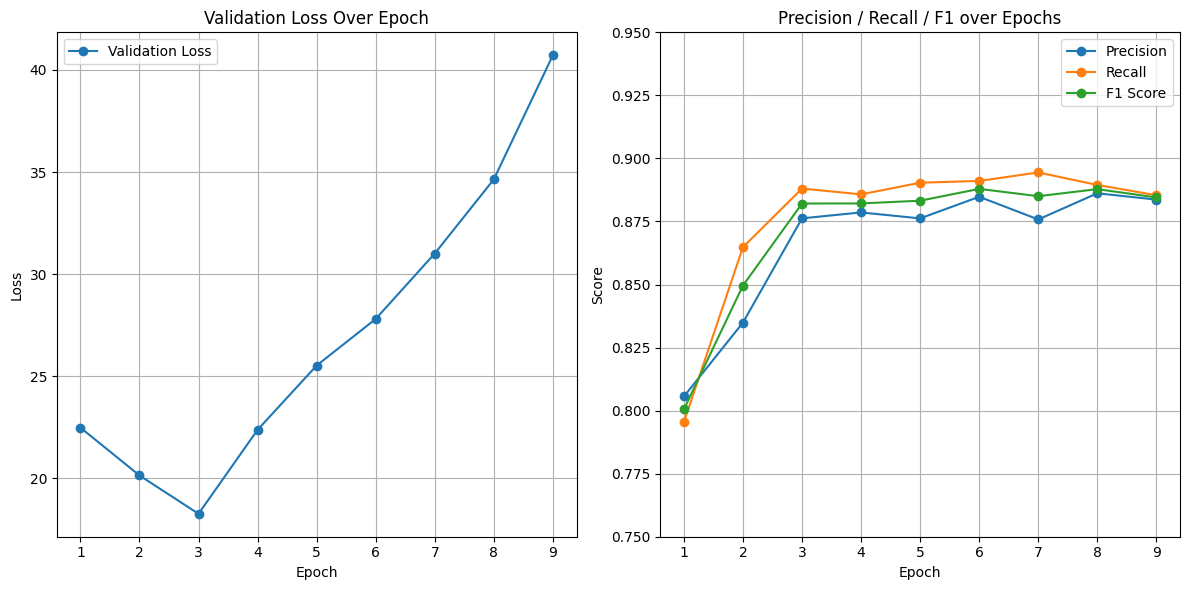

In [19]:
import matplotlib.pyplot as plt

# 에폭별 로그 데이터
epochs = list(range(1, 10))
train_loss = [None, None, None, 19.206800, 19.206800, 19.206800, 1.961100, 1.961100, 1.961100]
val_loss = [22.482336, 20.139780, 18.260933, 22.373323, 25.521544, 27.804270, 31.009399, 34.640724, 40.719376]
precision = [0.805605, 0.834903, 0.876247, 0.878585, 0.876222, 0.884798, 0.875803, 0.886179, 0.883676]
recall =    [0.795459, 0.864822, 0.888061, 0.885755, 0.890367, 0.891077, 0.894447, 0.889480, 0.885400]
f1 =        [0.800500, 0.849599, 0.882115, 0.882155, 0.883238, 0.887926, 0.885027, 0.887826, 0.884537]

# 그래프 크기 설정
plt.figure(figsize=(12, 6))

# Loss 그래프
plt.subplot(1, 2, 1)
# plt.plot(epochs[3:], train_loss[3:], label='Train Loss', marker='o')
plt.plot(epochs, val_loss, label='Validation Loss', marker='o')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Validation Loss Over Epoch")
plt.legend()
plt.grid(True)

# Precision / Recall / F1 그래프
plt.subplot(1, 2, 2)
plt.plot(epochs, precision, label='Precision', marker='o')
plt.plot(epochs, recall, label='Recall', marker='o')
plt.plot(epochs, f1, label='F1 Score', marker='o')
plt.xlabel("Epoch")
plt.ylabel("Score")
plt.title("Precision / Recall / F1 over Epochs")
plt.ylim(0.75, 0.95)
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [22]:
all_labels = list(set([int(label) for batch in train_dataset.labels for label in batch]))
print(sorted(all_labels))

[-100, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]


In [23]:
flat_train_labels = [label for sent in train_labels for label in sent if label != -100]
print("✅ max label:", max(flat_train_labels))
print("✅ min label:", min(flat_train_labels))
print("✅ num_labels:", len(label_list))

✅ max label: 10
✅ min label: 0
✅ num_labels: 11


In [24]:
all_labels_in_data = set(l for d in train_data for l in d["labels"])
print("📌 전체 라벨 종류:", sorted(all_labels_in_data))
for label in all_labels_in_data:
    if label not in label_to_id:
        print(f"⚠️ 존재하지 않는 라벨: {label}")

📌 전체 라벨 종류: ['B-DOSAGE', 'B-INGREDIENT', 'B-PERSONAL_INFO', 'B-SENSITIVE_CONDITION', 'B-SYMPTOM', 'I-DOSAGE', 'I-INGREDIENT', 'I-PERSONAL_INFO', 'I-SENSITIVE_CONDITION', 'I-SYMPTOM', 'O']


In [25]:
pip install seqeval

In [4]:
pip install pytorch-crf